## A Model Classifier based on GPU Inference Power Traces

In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision

### Power trace sequence and Target Label Helpers

In [34]:
# Given a directory path and batch size
# reads all the files in that directory
# for that specific batch size

# the files are selected by batch_size by file names
# example: *batch_1.tsv, *batch_5.tsv, etc.

def get_files(path, batch_size):
    return list(glob(os.path.join(path, f"*batch_{batch_size}.tsv")))

# Read a raw power trace file and convert column - power 
# values to a 1d tensor
def read_file(file_path):
    df = pd.read_csv(file_path, sep='\t', usecols=[0])
    return torch.tensor(df.iloc[:,0].values).unsqueeze(0)

# Get power trace tensors from list of files
def get_tensors(files):
    ten = []
    for file in files:
        file_tensor = read_file(file)
        ten.append(file_tensor.T)
    return ten

# Get power trace tensors for files in given 
# directory and given batch size
def get_model_tensors(file_dir, batch_size):
    files = get_files(file_dir, batch_size)
    model_tensors = get_tensors(files)
    return model_tensors

# Pad tensor values to max tensor dimension across index dimension
def pad(tensors):
    pad_ten = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
    return pad_ten.movedim(1,2)

# Truncate tensor values to smallest dimension 
def truncate(tensors):
    min = tensors[0].shape[0]
    for tens in tensors[1:]:
        if tens.shape[0] < min:
            min = tens.shape[0]
    temp_tensors = []
    for tens in tensors:
        temp_tensors.append(torch.narrow(tens,0,0,min))
    return torch.stack(temp_tensors).movedim(1,2)
        
# Get data and target label tensors
def get_data_target_tensors(file_dirs, labels, batch_size: int = 1, handle_varying:str = 'pad'):
    
    if len(file_dirs) != len(labels):
        raise Exception("Not enough target labels")
        
    model_tensors = []
    
    for file_dir in file_dirs:
        tensors = get_model_tensors(file_dir, batch_size)
        model_tensors.append(tensors)
        
    all_tensors = []
    
    for model in model_tensors:
        all_tensors += model
            
    if handle_varying == 'pad':
        in_tensor = pad(all_tensors)
    elif handle_varying == 'trunc':
        in_tensor = truncate(all_tensors)
    else:
        raise Exception("Not a valid option.")
        
    targets = []
    
    for label in labels:
        targets.append(torch.full((999,), label))
        
    target_tensor = torch.cat(targets)
    
    return in_tensor.to(torch.float32), target_tensor

# Split data and target tensors into train and test splits
def split_data(data, targets, fraction:float = 0.8):
    train_size = int(0.8 * data.shape[0])
    test_size = data.shape[0] - train_size
    return torch.utils.data.random_split(TensorDataset(data, targets), [train_size, test_size])


In [29]:
# Generic LSTM RNN time series classifier
# Model adapted from this forum question
# https://discuss.pytorch.org/t/how-to-use-lstm-for-a-time-series-classification-task/130559

class LSTMClassification(nn.Module):

    def __init__(self, input_dim, hidden_dim, target_size):
        super(LSTMClassification, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, target_size)

    def forward(self, input_):
        lstm_out, (h, c) = self.lstm(input_)
        logits = self.fc(lstm_out[:,-1])
        scores = F.sigmoid(logits)
        return scores
    
# Model training helper function
def train(model, trainloader, n_epochs):
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.2)

    history = {
        'loss': []
    }
    
    for epoch in range(n_epochs):
        losses = []
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            model.zero_grad()

            tag_scores = model(inputs)

            labels = labels.unsqueeze(1)
            
            loss = loss_function(tag_scores, labels.float())
            
            loss.backward()
            optimizer.step()
            losses.append(float(loss))
        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)
        #print("Epoch {} / {}: Loss = {:.3f}".format(epoch+1, n_epochs, avg_loss))
    return history

# Model evaluation helper function
def evaluate(model, testloader):
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.2)
    
    model.eval()
    history = {
        'loss': []
    }

    losses = []
    
    for i, data in enumerate(testloader, 0):
        inputs, labels = data

        tag_scores = model(inputs)
        labels = labels.unsqueeze(1)
        
        loss = loss_function(tag_scores, labels.float())
        loss.backward()
        losses.append(float(loss))
        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)
    return history

## Data loading and model setup

In [4]:
# directories with model power traces

res_dir = 'data/traces/resnet/'
vgg_dir = 'data/traces/vgg'
len_dir = 'data/traces/lenet/'

In [22]:
trace_batch_size = 10

data, targets = get_data_target_tensors(
                    [res_dir, vgg_dir, len_dir], 
                    [0, 1, 2], 
                    trace_batch_size, 
                    'pad'
                    )

train_dataset, test_dataset = split_data(data, targets)

trainloader = DataLoader(
                train_dataset, 
                batch_size=50, 
                shuffle=True
                )

testloader = DataLoader(
                test_dataset,
                batch_size=50
                )

model_10 = LSTMClassification(
                           data.shape[2], 
                           hidden_dim=6, 
                           target_size=1
                            )

training_hist_10 = train(model_10, trainloader, 100)

In [30]:
trace_batch_size = 1

data, targets = get_data_target_tensors(
                    [res_dir, vgg_dir, len_dir], 
                    [0, 1, 2], 
                    trace_batch_size, 
                    'pad'
                    )

train_dataset, test_dataset = split_data(data, targets)

trainloader = DataLoader(
                train_dataset, 
                batch_size=50, 
                shuffle=True
                )

testloader = DataLoader(
                test_dataset,
                batch_size=50
                )

model_1 = LSTMClassification(
                           data.shape[2], 
                           hidden_dim=6, 
                           target_size=1
                            )

training_hist_1 = train(model_1, trainloader, 100)

test_hist_1 = evaluate(model_1, testloader)

Test Loss:


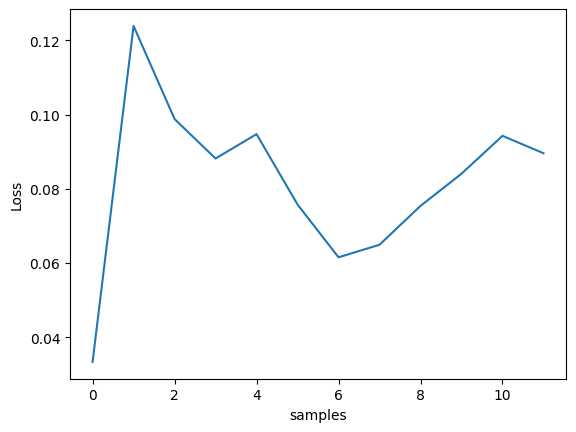

In [33]:
plt.plot(np.arange(len(test_hist_1['loss'])), np.array(test_hist_1['loss'], dtype=np.float32))
plt.xlabel("samples")
plt.ylabel("Loss")
print('Test Loss:')

In [8]:
trace_batch_size = 25

data, targets = get_data_target_tensors(
                    [res_dir, vgg_dir, len_dir], 
                    [0, 1, 2], 
                    trace_batch_size, 
                    'pad'
                    )

train_dataset, test_dataset = split_data(data, targets)

trainloader = DataLoader(
                train_dataset, 
                batch_size=50, 
                shuffle=True
                )

testloader = DataLoader(
                test_dataset,
                batch_size=50
                )

model_25 = LSTMClassification(
                           data.shape[2], 
                           hidden_dim=6, 
                           target_size=1
                            )

training_hist_25 = train(model_25, trainloader, 100)

Epoch 1 / 100: Loss = 0.414
Epoch 2 / 100: Loss = 0.297
Epoch 3 / 100: Loss = 0.248
Epoch 4 / 100: Loss = 0.207
Epoch 5 / 100: Loss = 0.178
Epoch 6 / 100: Loss = 0.162
Epoch 7 / 100: Loss = 0.152
Epoch 8 / 100: Loss = 0.145
Epoch 9 / 100: Loss = 0.139
Epoch 10 / 100: Loss = 0.135
Epoch 11 / 100: Loss = 0.132
Epoch 12 / 100: Loss = 0.128
Epoch 13 / 100: Loss = 0.125
Epoch 14 / 100: Loss = 0.123
Epoch 15 / 100: Loss = 0.122
Epoch 16 / 100: Loss = 0.121
Epoch 17 / 100: Loss = 0.121
Epoch 18 / 100: Loss = 0.120
Epoch 19 / 100: Loss = 0.120
Epoch 20 / 100: Loss = 0.120
Epoch 21 / 100: Loss = 0.119
Epoch 22 / 100: Loss = 0.119
Epoch 23 / 100: Loss = 0.119
Epoch 24 / 100: Loss = 0.118
Epoch 25 / 100: Loss = 0.117
Epoch 26 / 100: Loss = 0.117
Epoch 27 / 100: Loss = 0.117
Epoch 28 / 100: Loss = 0.116
Epoch 29 / 100: Loss = 0.116
Epoch 30 / 100: Loss = 0.116
Epoch 31 / 100: Loss = 0.116
Epoch 32 / 100: Loss = 0.116
Epoch 33 / 100: Loss = 0.116
Epoch 34 / 100: Loss = 0.116
Epoch 35 / 100: Loss = 

In [9]:
trace_batch_size = 50

data, targets = get_data_target_tensors(
                    [res_dir, vgg_dir, len_dir], 
                    [0, 1, 2], 
                    trace_batch_size, 
                    'pad'
                    )

train_dataset, test_dataset = split_data(data, targets)

trainloader = DataLoader(
                train_dataset, 
                batch_size=50, 
                shuffle=True
                )

testloader = DataLoader(
                test_dataset,
                batch_size=50
                )

model_50 = LSTMClassification(
                           data.shape[2], 
                           hidden_dim=6, 
                           target_size=1
                            )

training_hist_50 = train(model_50, trainloader, 100)

Epoch 1 / 100: Loss = 0.364
Epoch 2 / 100: Loss = 0.277
Epoch 3 / 100: Loss = 0.210
Epoch 4 / 100: Loss = 0.179
Epoch 5 / 100: Loss = 0.162
Epoch 6 / 100: Loss = 0.152
Epoch 7 / 100: Loss = 0.145
Epoch 8 / 100: Loss = 0.140
Epoch 9 / 100: Loss = 0.137
Epoch 10 / 100: Loss = 0.134
Epoch 11 / 100: Loss = 0.132
Epoch 12 / 100: Loss = 0.130
Epoch 13 / 100: Loss = 0.129
Epoch 14 / 100: Loss = 0.127
Epoch 15 / 100: Loss = 0.126
Epoch 16 / 100: Loss = 0.125
Epoch 17 / 100: Loss = 0.124
Epoch 18 / 100: Loss = 0.123
Epoch 19 / 100: Loss = 0.122
Epoch 20 / 100: Loss = 0.122
Epoch 21 / 100: Loss = 0.121
Epoch 22 / 100: Loss = 0.121
Epoch 23 / 100: Loss = 0.120
Epoch 24 / 100: Loss = 0.120
Epoch 25 / 100: Loss = 0.120
Epoch 26 / 100: Loss = 0.120
Epoch 27 / 100: Loss = 0.119
Epoch 28 / 100: Loss = 0.119
Epoch 29 / 100: Loss = 0.118
Epoch 30 / 100: Loss = 0.118
Epoch 31 / 100: Loss = 0.118
Epoch 32 / 100: Loss = 0.118
Epoch 33 / 100: Loss = 0.118
Epoch 34 / 100: Loss = 0.118
Epoch 35 / 100: Loss = 

In [10]:
trace_batch_size = 100

data, targets = get_data_target_tensors(
                    [res_dir, vgg_dir, len_dir], 
                    [0, 1, 2], 
                    trace_batch_size, 
                    'pad'
                    )

train_dataset, test_dataset = split_data(data, targets)

trainloader = DataLoader(
                train_dataset, 
                batch_size=50, 
                shuffle=True
                )

testloader = DataLoader(
                test_dataset,
                batch_size=50
                )

model_100 = LSTMClassification(
                           data.shape[2], 
                           hidden_dim=6, 
                           target_size=1
                            )

training_hist_100 = train(model_100, trainloader, 100)

Epoch 1 / 100: Loss = 0.376
Epoch 2 / 100: Loss = 0.245
Epoch 3 / 100: Loss = 0.196
Epoch 4 / 100: Loss = 0.172
Epoch 5 / 100: Loss = 0.158
Epoch 6 / 100: Loss = 0.149
Epoch 7 / 100: Loss = 0.143
Epoch 8 / 100: Loss = 0.139
Epoch 9 / 100: Loss = 0.135
Epoch 10 / 100: Loss = 0.133
Epoch 11 / 100: Loss = 0.131
Epoch 12 / 100: Loss = 0.129
Epoch 13 / 100: Loss = 0.128
Epoch 14 / 100: Loss = 0.127
Epoch 15 / 100: Loss = 0.126
Epoch 16 / 100: Loss = 0.125
Epoch 17 / 100: Loss = 0.124
Epoch 18 / 100: Loss = 0.123
Epoch 19 / 100: Loss = 0.123
Epoch 20 / 100: Loss = 0.122
Epoch 21 / 100: Loss = 0.122
Epoch 22 / 100: Loss = 0.121
Epoch 23 / 100: Loss = 0.121
Epoch 24 / 100: Loss = 0.120
Epoch 25 / 100: Loss = 0.120
Epoch 26 / 100: Loss = 0.120
Epoch 27 / 100: Loss = 0.119
Epoch 28 / 100: Loss = 0.119
Epoch 29 / 100: Loss = 0.119
Epoch 30 / 100: Loss = 0.119
Epoch 31 / 100: Loss = 0.118
Epoch 32 / 100: Loss = 0.118
Epoch 33 / 100: Loss = 0.118
Epoch 34 / 100: Loss = 0.118
Epoch 35 / 100: Loss = 

Training Loss:


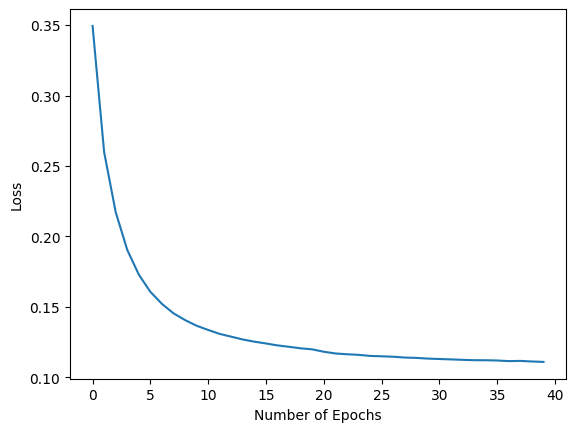

In [17]:

plt.plot(np.arange(40), np.array(training_hist_1['loss'][:40], dtype=np.float32))
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
print('Training Loss:')